In [1]:
import sys ; sys.path.append("/Users/katherinegarcia/Desktop/computerVision/Tarea1/") # osx
from skimage.util import view_as_windows
from math import ceil
import numpy as np
import cv2 as cv
import plot
import os

In [2]:
def loadImg(path = '/Users/katherinegarcia/Desktop/computerVision/imgs/'):
    """Load img from imgs folder

    Args:
        path (str): path of file

    Returns:
        im: image in grayscale
    """
    # a color
    im = cv.imread(os.path.join('bike_and_pedestrian.png'), cv.IMREAD_COLOR)
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

    #BW
    # im = cv.imread(os.path.join(path,'p1.png'), cv.IMREAD_GRAYSCALE)
    return im

### Padding

In [3]:
def pad(img, r, value, type=np.uint8):
    """Pad an image with value v with a border of r pixels.
    Args:
        img (numpy array): Image to pad.
        r (int): Number of pixels to pad around border.
        value (int): Value to use for padding.
        type (np.types): Type of new padded image.
 
    Returns:
        padded (numpy array): Padded image.
    """
    rows, cols = img.shape
    R = rows + 2*r
    C = cols + 2*r
     
    padded = np.full((R, C), value, dtype=type)
    padded[r:-r,r:-r] = img
    return padded

### Aplicar un Kernel

In [4]:
def filterImg(img, kernel, dtype = np.float64):
    """_summary_

    Args:
        img (_type_): _description_
        kernel (_type_): _description_
        dtype (_type_): _description_

    Returns:
        _type_: _description_
    """
    # check that img is BW 
    assert len(img.shape) == 2

    # allow non square kernels with odd shape 
    # but validate that the mayor axis size is odd
    assert (max(kernel.shape)%2)!=0

    # create placeholder for result
    # crear una matriz como variable de salida
    convolution = np.zeros_like(img, dtype=dtype)
    rK, cK = kernel.shape

    R = max(rK, cK)//2

    # pnerle padding al img
    padded = pad(img, R ,-1)
    r, c = padded.shape

    for i in range(1, r-1):
        for j in range(1, c-1):
            imgN = padded[i-R:i+R+1, j-R:j+R+1]
            pValue = np.multiply(imgN, kernel).sum()
            convolution[i-1,j-1] = pValue
    
    return convolution

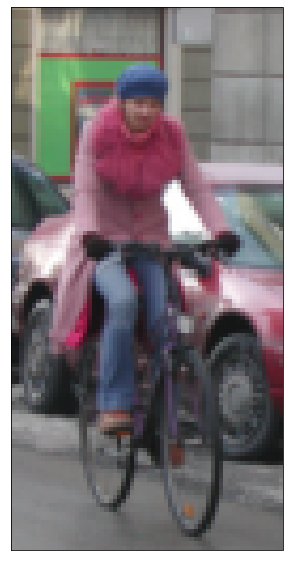

In [5]:
img = loadImg()
img[:,:,].shape
plot.imgView(img)

In [6]:
kernelX = np.array([-1,0,1]).reshape(1,-1)
kernelY = np.array([-1,0,1]).reshape(-1,1)

### Funcs :) ⬇️

In [7]:
def grad2magn(gx, gy):
    """ Compute the magnitude corresponding to gx and gy gradient matrices.
    Args:
        gx (numpy.array): Gradient in the x direction.
        gy (numpy.array): Gradient in the y direction.
    Returns:
        magnitudes (numpy.array): Magnitudes computed.
    """
    
    magn = np.sqrt(((gx**2)+(gy**2)))
    return magn

In [8]:
def grad2angle(gx,gy):
    """ Compute the angle corresponding to gx and gy gradient matrices.
    Atan2 result is always between -pi and pi.
    
    Args:
        gx (numpy array): Gradient in the x direction.
        gy (numpy array): Gradient in the y direction.
        
    Returns:
        angles (numpy array): Angles computed by the np.arctan2 function.
    """
    
    dir = np.arctan2(gy,gx)
    return dir

In [9]:
def rad2deg(rad):
    """ Convert an angle measure from radians to degrees.
    Arg:
        - rad (float): Angle in radians
    Returs:
        deg (float): Angle in degrees
    """
    
    deg = (rad*180)/ np.pi
    return deg

In [10]:
def convolveRGB(img, kernelX, kernelY):
    """ Compute the gradient of an RGB image.
    Args:
        img (numpy array): Source Image.
        kx (numpy.array): Kernel for the x direction.
        ky (numpy.array): Kernel for the y direction.
        unsigned (bool): Select if gradient computation is signed or unsigned.
        
    Returns:
        gradients (list): List of numpy arrays containing the x and y convolution per channel.
    """
   
    gradients = []

   # pasarle convolve
    for i in range(len(img.shape)):
        c = img[:,:,i]

        gradXc = filterImg(c, kernelX)
        gradYc = filterImg(c, kernelY)
        
        gradients.append([gradXc, gradYc])

    return gradients

In [11]:
def grad2vect(gradients, degrees=False, unsigned=False):
    """ Compute from a vector of horizontal 
    and vertical gradients, gx and gy, the corresponding rgb
    magnitudes and angle array.
    
    Args:
        gradients (list): Pairs of gx and gy gradients in a list. [[gx,gy],[gx,gy],[gx,gy]]
        degrees (bool): Output angles in degrees
        unsigned (bool): Discard angle sign information
        
    Returns:
        magnitude (np.array): 3 channel image of magnitudes.
        angle (np.array): 3 channel image of angles.
    """
    
    magnitude = []
    angles = []
    for gx, gy in gradients:
        magnitude.append(grad2magn(gx,gy))
        angles.append(grad2angle(gx,gy))

    # returns (128, 64, 3) not (3, 64, 128)
    magnitude = cv.merge(magnitude)
    angles = cv.merge(angles)

    if degrees:
        angles = rad2deg(angles)
    
    if unsigned:
        angles = np.absolute(angles)
    
    return np.array(magnitude), np.array(angles)

In [46]:
def hogVector(magnitude, angles):
    """ Build magnitude and orientation matrices required by Hog.
        Max magnitude per channel is selected pixelwise and the corresponding orientation.

    Args:
        magnitude (list of np.array): List of 2D arrays with channel magnitudes.
        angles (list of np.array): List of 2D arrays with channel orientations. Must be expressed in degrees.
    Returns:
        mag, ang: (np.array): Maximum magnitude per channel (mag) and corresponding orientation (ang)
    """

    img_shape = magnitude.shape
    mag = np.zeros((img_shape[0], img_shape[1]))
    ang = np.zeros((img_shape[0], img_shape[1]))

    for row in range(magnitude.shape[0]):
        for col in range(magnitude.shape[1]):
            maxChannel = np.argmax(magnitude[row, col])
            maxMagn = magnitude[row, col, maxChannel]
            maxAng = angles[row, col, maxChannel]
            mag[row, col]=(maxMagn)
            ang[row, col]=(maxAng)
    
    # mag = cv.merge(np.array(mag))
    # ang = cv.merge(np.array(ang))
    return mag, ang

In [43]:
def hogHist(mag, ang):
    """Build Hog histogram
    
    Args:
        mag (np.array): 2D array of magnitudes. Size 8X8
        ang (np.array): 2D array of orientations. Must be expressed in degrees. Size 8X8
        
    Returns:
        hogHist (np.array): Histogram of 9 bins for the. [12,1234,31231,12312,213,23342,432,54,53]
    """
    # [0 | 20 | 40 | 60 | 80 | 100 | 120 | 140 | 160 | 180] #  9 boxes of 20-degree increments
    hogHist = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
    step = 20

    # print(np.max(ang))
    # print(np.min(ang))
    assert not np.max(ang) > 180 and not np.min(ang) < 0
    
    for row in range(mag.shape[0]): # mag -> 8x8
        for col in range(mag.shape[1]):
            angBin = ceil(ang[row, col] / step) # no. of bin
            angQty = angBin - ang[row, col] / step # amount
            # angQty = round(((ang[row, col] / step ) % 1), 3) # amount
            actualMag = mag[row, col]
            
            hogHist[angBin] += actualMag * (1 - angQty)
            
            # if angBin == 0: # para tirar los datos a; 160 y no al 180 
            #     hogHist[angBin - 2] += actualMag * (angQty) # + por el floor 
            # else:
            hogHist[angBin - 1] += actualMag * (angQty) # + por el floor 
    
    # 180 merge with 0
    hogHist[0] += hogHist[-1]
    hogHist.pop(-1) # remove 180

    return hogHist

In [60]:
def normL2(hist):
    norm = hist / np.sqrt( np.sum( hist ** 2 ) )
    return norm

## Proceso

In [14]:
# convolve
grads = convolveRGB(img, kernelX, kernelY)
# grads 2 vector
magnitude, angles = grad2vect(grads, degrees=True, unsigned=True)

In [16]:
# Max magnitude per channel is selected pixelwise and the corresponding orientation
magnitude, angles = hogVector(magnitude, angles)

In [48]:
# All hists per img
histsImg = []

windowsMag = view_as_windows(magnitude, (8,8), 8)
windowsAng = view_as_windows(angles, (8,8), 8)

for r in range(windowsMag.shape[0]): # Filas 
    for c in range(windowsMag.shape[1]): # Cols
        histsImg.append(hogHist(windowsMag[r][c],windowsAng[r][c]))

histsImg = np.array(histsImg).reshape(magnitude.shape[0]//8, magnitude.shape[1]//8, 9)
histsImg.shape

(16, 8, 9)

In [61]:
final = []
winds = view_as_windows(histsImg, (2, 2, 9))
for r in range(winds.shape[0]): # Filas 
    for c in range(winds.shape[1]): # Cols
        vect = np.reshape(winds[r][c], -1)
        vect = normL2(vect)
        final.append(vect)

final = np.reshape(np.array(final), -1)
# final = np.array(final)
final.shape

(3780,)

In [34]:
magnitude.shape

(128, 64)

In [35]:
(view_as_windows(magnitude, (8,8), 8)).shape[0]

16

In [56]:
histsImg[0,2]

array([ 341.91606023,   76.92428183,   51.81400981,  235.72246391,
       2640.7094213 , 2989.37539924,  273.22227716,  486.61030447,
        592.27484455])

In [52]:
winds[0][0][0]

array([[[5125.40621621,  817.7611497 ,  100.0812645 ,  330.13688712,
         1511.94411946, 1194.50026915,  502.0888665 ,  925.45830565,
          965.23853978],
        [ 153.30865714,  193.11972804,  374.36243856,  803.98915168,
         3971.59685087, 2558.72907708,  394.90864808,  430.69660212,
          294.78657752]],

       [[6828.38288845, 1521.57330805,  325.46491196,   64.85831313,
          245.49918428,   92.47054166,  446.82187213,  432.41594285,
         1086.98179373],
        [ 274.03091914,  213.43338419,   84.30406117,  148.34914197,
         3085.57111538, 2914.96227973,  317.44680231,   83.42975916,
          311.01414338]]])

In [97]:
winds[0][1][0]

array([[[ 153.29923451,  193.14163633,  374.35698575,  804.03244039,
         3971.45522153, 2558.79188068,  395.00577883,  430.59042468,
          294.8241284 ],
        [ 342.08596695,   76.89720036,   51.8258376 ,  235.63262393,
         2641.09634408, 2989.05042583,  273.26643407,  486.64386494,
          592.07036475]],

       [[ 262.06613589,  213.46699162,   84.24266914,  148.45673914,
         3085.21013118, 2915.18319689,  317.485957  ,   83.45339839,
          322.97638716],
        [  48.04604619,   84.35888984,   24.22029289,   27.55402816,
         2866.26632353, 3916.26092053,  214.14869846,   32.97896155,
          265.168085  ]]])

In [49]:
# no cambiar es con el codigo antes del if angbin = 0
winds[0][1][0]

array([[[ 153.30865714,  193.11972804,  374.36243856,  803.98915168,
         3971.59685087, 2558.72907708,  394.90864808,  430.69660212,
          294.78657752],
        [ 341.91606023,   76.92428183,   51.81400981,  235.72246391,
         2640.7094213 , 2989.37539924,  273.22227716,  486.61030447,
          592.27484455]],

       [[ 274.03091914,  213.43338419,   84.30406117,  148.34914197,
         3085.57111538, 2914.96227973,  317.44680231,   83.42975916,
          311.01414338],
        [  48.00664012,   84.38018547,   24.22380201,   27.61295291,
         2866.11098717, 3916.30598405,  214.19374802,   32.99811071,
          265.1698357 ]]])

In [63]:
final

array([0.45757439, 0.07300623, 0.00893483, ..., 0.02237155, 0.00613255,
       0.00152369])

In [62]:
if (respuesta == final).all():
    print("IGUAL :)")
else:
    print("NO :(")

NO :(


In [ ]:
# 8*16*9
# ultimo vector de 3780

In [64]:
respuesta = np.load("bike_and_pedestrian_hog_fd.npy")
respuesta

array([0.45757439, 0.07300623, 0.00893483, ..., 0.02237155, 0.00613255,
       0.00152369])

In [65]:
import laboratorio_2
laboratorio_2.hog('bike_and_pedestrian.png')

array([0.45757439, 0.07300623, 0.00893483, ..., 0.02237155, 0.00613255,
       0.00152369])